In [89]:
#### Day 1 ####

In [90]:
## Intermediate homework for certification:
## Exercise: calculate the prediction for 100% pos, and 100% neg review

In [115]:
%matplotlib inline 
datadir = '/Users/Laure/' # The datadir fixture allows test functions and methods to access resources in so-called “data directories”.

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print('Dataset %s has already been downloaded to %s' % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' %filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
            print('Downloaded dataset %s and saved it to %s' % (dataset_name, datadir))
            
            
dataset = 'Baby'
download_data(dataset, datadir)

Dataset Baby has already been downloaded to /Users/Laure/


In [117]:
import json

def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
            for line in f:
                item_hash = hash(line)
                item = json.loads(line)
                item['hash'] = item_hash
                data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

baby = load_data(dataset, datadir)

print(baby[9426])

Loaded 160792 data for dataset Baby
{'reviewerID': 'A2H4QWDVXARPAU', 'asin': 'B0000TYHD2', 'reviewerName': 'Erin White "Erin"', 'helpful': [7, 8], 'reviewText': "I bought this pump for my new baby because it just as others below have said it looks more comfortable than others and it is! Including Medela. With my other child I encountered breastfeeding problems and had a horrible cheap pump. Now with my new baby she was born with a heart problem (she is fine now after a long road to recovery) and had to stay in the hospital for an extended length of time. Meanwhile I had other children at home and we live 6 hours away from our family and so I had no choice but to divide my time between the hospital and home, which meant I needed a hospital grade pump originally I rented one from the hospital (Medela) and it made my breasts hurt really bad. On the way home from the hospital I stopped in at Babiesrus and bought this pump because it was on our registry (we studied and found it to be more c

In [119]:
def partition_train_validation_test(data):
    data_train = [item for item in data if item['hash']%10<=5]
    data_valid = [item for item in data if item['hash']%10 in [6,7]]
    data_test = [item for item in data if item['hash']%10 in [8,9]]
    return data_train, data_valid, data_test

baby_train, baby_valid, baby_test = partition_train_validation_test(baby)

print('Now we have', len(baby_train), 'training eamples', len(baby_valid), 'validation examples and', len(baby_test), "test examples")

Now we have 96337 training eamples 32226 validation examples and 32229 test examples


In [193]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [194]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower())
            if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens
            

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0,0
    for t in tokens:
        if t in positive_words:
            count_pos +=1
        if t in negative_words:
            count_neg +=1
    count_all = len(tokens)
    if count_all !=0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [125]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)

print("We found a fraction of %f %% positive words for example %d" % (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" % (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])

We found a fraction of 100.000000 % positive words for example 5911
{'reviewerID': 'AKU0ZZ3IEZW42', 'asin': 'B0001BUKA8', 'helpful': [0, 0], 'reviewText': 'useful peace', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': 5820922656776727582}
We found a fraction of 100.000000 % negative words for example 15741
{'reviewerID': 'A2416HDN71TOGG', 'asin': 'B000HZEQSU', 'reviewerName': 'Elizabeth Evans', 'helpful': [0, 0], 'reviewText': 'uncomfortable', 'overall': 1.0, 'summary': 'One Star', 'unixReviewTime': 1404691200, 'reviewTime': '07 7, 2014', 'hash': 5454254189285250170}


In [127]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)

print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (96337, 2)
Our target vector is one-dimensional and has shape (96337,)


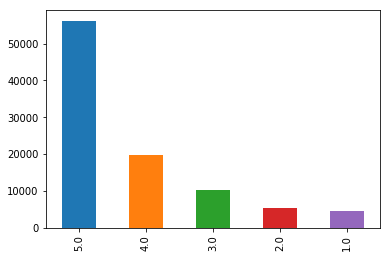

In [129]:
import pandas

pandas.Series(Y_train).value_counts().plot.bar()

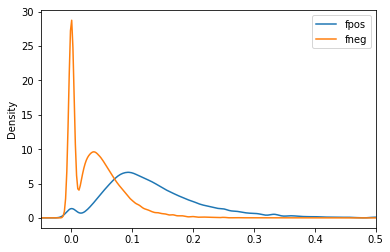

In [131]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

In [133]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.2145066730293066
The coefficient for the fneg variable is -5.652362626053202
The intercept is 4.013629000068324


In [135]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.656530 stars
This is the same as 4.656530 stars


In [137]:
features = [[1, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 1*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 7.228136 stars
This is the same as 7.228136 stars


In [139]:
features = [[0, 1]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0*lreg.coef_[0] + 1*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is -1.638734 stars
This is the same as -1.638734 stars


As expected, we get a very odd prediction. The issue lies on the fact that since we have not told our predictor 
that all ratings must lie between 1 and 5 stars, it became a bit overenthusiastic in its predictions for these
extreme examples. The end of course aims to achieve that with predict_lreg.

In [141]:
## Exercise: repeat this same process for "Apps for Android" dataset

In [187]:
dataset2 = 'Apps_for_Android'

# Download and save data

download_data(dataset, datadir)

Dataset Apps_for_Android has already been downloaded to /Users/Laure/


In [188]:
# Load data

apps = load_data(dataset, datadir)

print(apps[9426])

Loaded 752937 data for dataset Apps_for_Android
{'reviewerID': 'A37ZP4RA4ERTG2', 'asin': 'B004GYYQLA', 'reviewerName': 'Cookie', 'helpful': [7, 8], 'reviewText': "I don't mind ads as much as others so that wasn't a big deal, but it asked for all of this information about you, like your e-mail and zip code, so I deleted it. This ad is not for people who dislike giving out their information.", 'overall': 1.0, 'summary': 'Asks for your info', 'unixReviewTime': 1325289600, 'reviewTime': '12 31, 2011', 'hash': -7479212533070807264}


In [189]:
#  Partition data for training, validating and testing the analyser 

apps_train, apps_valid, apps_test = partition_train_validation_test(apps)

print('Now we have', len(apps_train), 'training examples', len(apps_valid), ', validation examples and', len(apps_test), "test examples.")

Now we have 451816 training examples 150623 , validation examples and 150498 test examples.


In [186]:
# Define X_train, list of fraction of pos/neg words in section "reviewText", for each review.

X_train = dataset_to_matrix(apps_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)

print("We found a fraction of %f %% positive words for example %d" % (100.*X_train[most_pos, 0], most_pos))
print(apps_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" % (100.*X_train[most_neg, 1], most_neg))
print(apps_train[most_neg])

We found a fraction of 100.000000 % positive words for example 850
{'reviewerID': 'AWUDE6LOH5Y2Q', 'asin': 'B004DLPXAO', 'reviewerName': 'Amazon Customer', 'helpful': [0, 0], 'reviewText': 'Love it!', 'overall': 5.0, 'summary': 'Take you Kindle Library along whenever you have your phone!', 'unixReviewTime': 1404691200, 'reviewTime': '07 7, 2014', 'hash': -7311770520111658757}
We found a fraction of 100.000000 % negative words for example 6427
{'reviewerID': 'A1HZYCWWJ53TS5', 'asin': 'B004HE5TAG', 'helpful': [0, 0], 'reviewText': 'boring', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': 508774179190454234}


In [190]:
# Define Y_train, the number of starts overall atrributed by the reviewer, for each review.

Y_train = dataset_to_targets(apps_train)

print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (451816, 2)
Our target vector is one-dimensional and has shape (451816,)


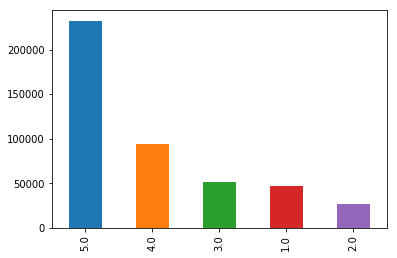

In [153]:
# Plots

pandas.Series(Y_train).value_counts().plot.bar()

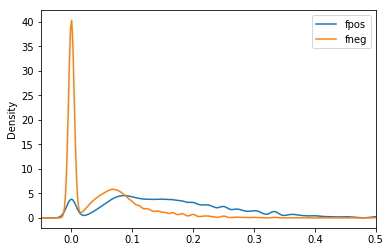

In [155]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

In [157]:
# Predictions

In [159]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.7653261633820923
The coefficient for the fneg variable is -3.9136953513070405
The intercept is 3.5486485002103008


The star rating we would expect for a review that contains neither positive nor negative words (fpos==0 and fneg==0)
is 3.5.

In [161]:
features = [[0.25, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.25*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.489980 stars
This is the same as 4.489980 stars


In [163]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train)

In [165]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]:
    analyze_training_example(i)

Training example number 0
True rating = 5.000000 stars, expected rating = 4.113447 stars
Features = 0.150000 / 0.000000
Review text = My 1 year old goes back to this game over and over again.  It is simple but very easy for a toddler to use.  I've even caught my 5 year old playing it as well.  Good app for little guys!
Training example number 10000
True rating = 4.000000 stars, expected rating = 4.000556 stars
Features = 0.151515 / 0.030303
Review text = I have some phone pics that were taken in dark settings and this app did a very good job of brightening the image without washing the picture out. I also like the simplicity of the slider settings. I'll definitely keep this around to enhance some pics. I agree that this should probably be a $1-$2 app. $5 seems a bit much. Glad I got it for free.
Training example number 20000
True rating = 1.000000 stars, expected rating = 3.269099 stars
Features = 0.000000 / 0.071429
Review text = Never got to use it. First time, my tablet started acti

Examples number 2000 didn't work.
Examples number 1000 and 5000 are quite well predicted.
Examples number 0 and 3000 are a bit off.

In [167]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)

The mean absolute error on the training data is 0.990830 stars


Mean absolute error is pretty high, so the prediction is pretty accurate!

In [169]:
#### Day 2 ####

In [171]:
## Exercise (Intermediate HW)
# Change the treshold from 0.5 to 0.2, and rerun the code.

In [173]:
"The following is done for the last example, i.e. for 'Apps for Android'"

"The following is done for the last example, i.e. for 'Apps for Android'"

In [175]:
def discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))
print(D_train[:10])

The training data contains 27.635586 % dissatisfied customers
[False False False False False  True False  True False  True]


In [177]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, D_train)

prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 6427
True rating = 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.996447
Features = 0.000000 / 1.000000
Review text = boring


In [179]:
analyze_training_example_2(min_prob2)

Training example number 850
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000189
Features = 1.000000 / 0.000000
Review text = Love it!


In [180]:
from sklearn.metrics import precision_score, recall_score

precision2 = precision_score(D_train, pred2_train)

recall2 = recall_score(D_train, pred2_train)

print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.652477 and recall = 0.228332


In [181]:
pred2_train = prob2_train > 0.2

precision2 = precision_score(D_train, pred2_train)

recall2 = recall_score(D_train, pred2_train)

print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.372590 and recall = 0.840128


In [182]:
# Give a commentary in plain English about how that changed precision and recall. 
# What does that mean? What is now included that wasn't before? 
# What part of it is good? What is bad from our Task perspective. 
# Remember: our task was to identify Dissatisfied reviews.

Precision: how many selected items are relevant?
Recall: how many relevant items are selected?

Treshold = 50% -> precision = 0.65 and recall = 0.23
Treshold = 20% -> precision = 0.37 and recall = 0.84

So for the case of a treshold of 50%(20%), it means:
Recall = 0.23 (0.84): We only found 23% (84%) of the relevant results, so 77% (16%) are false negatives, many reviewers are actually dissatisfied but we didn't manage to catch them.
Precision = 0.65 (0.37): out of those that we have identified, 65% are actually correctly identified. So anything that we have flagged as dissatisfied customers, only 65% (37%) are actually dissatisfied, and 35% (63%) are actually ok/satisfied but we thought they weren't.

So, what does it actually means changing the treshold from 0.5 to 0.2:
"Treshold = 0.5" means:  if we are 50% sure that the person is dissatisfied we will classify him as dissatisfied.
"Treshold = 0.2" means: if we think that a reviewer might be dissatisfied, there's actually only 20% chance that he might be dissatisfied, but we are still going to flag him as a dissatisfied reviewer because we don't want to miss him out in case he actually is.
Therefore, when we lower the treshold, the recall increases i.e. we catch more of the actual dissatisfied people, which was our Task perspective, but the precision drops because we accept more and more reviewers.

In [ ]:
#### Day 3 ####

In [183]:
## Exercise: Add two features:
#     (1) length of review (in thousands of character) - truncate at 2,500
#     (2) percentage of exclamation marks (in %)

Included in the next exercise.

In [ ]:
## Exercise: Refactor day_3's code.

In [1]:
import urllib.request, os, gzip
import numpy
import json
%matplotlib inline 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation

sia = SentimentIntensityAnalyzer()

/Users/Laure/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print('Dataset %s has already been downloaded to %s' % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' %filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
            print('Downloaded dataset %s and saved it to %s' % (dataset_name, datadir))

In [3]:
def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

In [4]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test

In [5]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())
eng_stopwords = set(stopwords.words('english'))
negated_stopwords = set(x+"_NEG" for x in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)        # set union
all_positive_words = positive_words.union({x+"_NEG" for x in negative_words})
all_negative_words = negative_words.union({x+"_NEG" for x in positive_words})

In [6]:
def tokenize_with_negation(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

In [7]:
def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    # count how many positive and negative words occur in the text
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_positive_words:
            count_pos += 1
        if t in all_negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:  # avoid division by zero
        return 0., 0.

In [8]:
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item['reviewText'])) for item in data])

In [9]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

In [10]:
def sia_features(dataset):
    """For each review text in the dataset, extract:
       (1) the mean positive sentiment over all sentences
       (2) the mean neutral sentiment over all sentences
       (3) the mean negative sentiment over all sentences
       (4) the maximum positive sentiment over all sentences
       (5) the maximum neutral sentiment over all sentences
       (6) the maximum negative sentiment over all sentences"""
    feat_matrix = numpy.empty((len(dataset), 6))
    for i in range(len(dataset)):
        sentences = sent_tokenize(dataset[i]['reviewText'])
        nsent = len(sentences)
        if nsent:
            sentence_polarities = numpy.empty((nsent, 3))
            for j in range(nsent):
                polarity = sia.polarity_scores(sentences[j])
                sentence_polarities[j, 0] = polarity['pos']
                sentence_polarities[j, 1] = polarity['neu']
                sentence_polarities[j, 2] = polarity['neg']
            feat_matrix[i, 0:3] = numpy.mean(sentence_polarities, axis=0) # mean over the columns
            feat_matrix[i, 3:6] = numpy.max(sentence_polarities, axis=0) # maximum over the columns
        else:
            feat_matrix[i, 0:6] = 0.0
    return feat_matrix

In [11]:
def len_features(dataset):
    """Add two features:
       (1) length of review (in thousands of characters) - truncate at 2,500
       (2) percentage of exclamation marks (in %)"""
    feat_matrix = numpy.empty((len(dataset), 2))
    for i in range(len(dataset)):
        text = dataset[i]['reviewText']
        feat_matrix[i, 0] = len(text) / 1000.
        if text:
            feat_matrix[i, 1] = 100. * text.count('!') / len(text)
        else:
            feat_matrix[i, 1] = 0.0
    feat_matrix[feat_matrix>2.5] = 2.5
    return feat_matrix

In [12]:
def error(an_input):
    X_neg = dataset_to_matrix_with_neg(an_input)
    Y = dataset_to_targets(an_input)
    sia_data = sia_features(an_input)
    len_data = len_features(an_input)
    X_augmented = numpy.concatenate((X_neg, sia_data, len_data), axis=1) # stack horizontally
    
    lreg_augmented = LinearRegression().fit(X_augmented, Y)
    pred_lreg_augmented = lreg_augmented.predict(X_augmented)
    mae_lreg_augmented = mean_absolute_error(pred_lreg_augmented, Y)

    rf_augmented = RandomForestRegressor().fit(X_augmented, Y)
    pred_rf_augmented = rf_augmented.predict(X_augmented)
    mae_rf_augmented = mean_absolute_error(pred_rf_augmented, Y)
    
    print("On this set, we get %f error for the linear regression" % mae_lreg_augmented)
    print("And %f for the random forest regression" % mae_rf_augmented)

In [13]:
def grabAndPartition(set_name, datadir):
    # load the data...
    a_set = load_data(set_name, datadir)
    
    # partition   
    set_train, set_valid, set_test = partition_train_validation_test(a_set)
    
    return set_train, set_valid, set_test   

In [14]:
datadir = '/Users/Laure/' # The datadir fixture allows test functions and methods to access resources in so-called “data directories”.

train, valid, test = grabAndPartition('Baby', datadir)

Loaded 160792 data for dataset Baby


In [15]:
error(train)

On this set, we get 0.756192 error for the linear regression
And 0.282817 for the random forest regression


In [16]:
error(valid)

On this set, we get 0.756387 error for the linear regression
And 0.281893 for the random forest regression


In [17]:
error(test)

On this set, we get 0.751177 error for the linear regression
And 0.279483 for the random forest regression
